In [206]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx
import pylab as graphplot
from collections import Counter

from sklearn.metrics import jaccard_similarity_score
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.externals import joblib
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix ,accuracy_score


# LOAD DATA 
Create Dataset

In [208]:
cd "C:\Users\gurin\Desktop\Resume\Projects\Recomender System"

C:\Users\gurin\Desktop\Resume\Projects\Recomender System


In [209]:
followerFile = pd.read_csv("follows.csv") 
interestFile = pd.read_csv("interests.csv")

# sample of the data 
# here in the first row ...user_id 4 follows user_id 2 ...
# Thus follower_id is 4 and followee_id is 2 
followerFile.head(3)

,follower_id,followee_id
0,4,2
1,2,4
2,6,2


# Building Dictionaries
To relate lets follow a user say "SAM" (note in our data we have only numbers for users : Data privacy man!!!!)
So we have to build 3 dictionaries 
1) for all other users SAM is following
2) for all users Following SAM
3) for all the interest of SAM

In [210]:
# dictionary to show User is FOLLOWER of
FollowerList = {k:interest["followee_id"].tolist() for k,interest in followerFile.groupby("follower_id")}

# dictionary to show User is being followed by 

FolloweeList = {k:interest["follower_id"].tolist() for k,interest in followerFile.groupby("followee_id")}

# to show interest list of a user

InterestUserList = {k:interest["category"].tolist() for k,interest in interestFile.groupby("user_id")}  

print " The dictionary for FOLLOWER will look like this ... if we select SAM (say user 2)" , FollowerList[2]

print ""
print " the dictionary for FOLLOWEE  will look like this ... if we select SAM (say user 2) " , FolloweeList[2]

print ""

print " the dictionary for INTEREST will look like this ... if we select SAM (say user 2)" , InterestUserList[2]



 The dictionary for FOLLOWER will look like this ... if we select SAM (say user 2) [4L, 20L, 46L, 6L, 702L, 62L, 78L, 120L, 36L, 16L, 12L, 5860L, 22L]

 the dictionary for FOLLOWEE  will look like this ... if we select SAM (say user 2)  [4L, 6L, 8L, 24L, 12L, 10L, 40L, 44L, 46L, 56L, 70L, 444L, 92L, 138L, 50L, 338L, 634L, 36L, 426L, 196L, 62L, 596L, 2418L, 2746L, 26L, 5114L, 1574L, 6142L, 5736L, 22L]

 the dictionary for INTEREST will look like this ... if we select SAM (say user 2) ['Guadeloupe', 'Bucharest', 'Blues', 'Algeria', 'Government', 'Switzerland']


# THE DISTANCE MEASURE :
______________________

I looked at the various distance measures and there are over a 100 of them !!!!

From Euclidian , To Cosine , I looked at them to zone on to the chosen one........

Our DISTANCE MEASURE --------JACKARD INDEX 

JACKARD index for a user A and user B is calculated as  (Intersection of A and B) / (Union of A and B)

This index works great for us it Rewards for Comminality and at the same time does not Penalise for Differnces. This key feature is what works for social networks as opposed to Eucledian disatance that Penalises for Differnces, Thus making it not appropiate for network distances. 
________________________________________________________________________________________________________________________________

As we have to draw information about 3 pieces of information  - Follower , Followee , and Interests , We need to build 3 Jackard Index one for each of them . 

After much analysis and a stroke of origional thinking , we decided to name them
JaccardFollowerList
JaccardFolloweeList
JaccardInterestList

In [211]:
def ComputeJaccardSimilarityIndexes(listToAnalyze):
    
    '''
    will take as input 
    
    an array with two columns - Follower_id , Followee_id
    
    will retrun 3 Lists :
   
    JaccardFollowerList
    JaccardFolloweeList
    JaccardInterestList
    
    Logic for script:
    __________________
    
    1)As we need to find comonality and union , we are using "SET" which has convinent command "Interscetion" to find the 
    common elements in sets. 
    2) once we get the set we convert it into  a list and then take the count of the number of elements
    3) since it is a division , we convert the count to float, cause we may get '0' in integer division. 
    4) As we need three list and for all enteries therefore, we run 1 for loop and within that 3 if - else.
             
    '''
    
	#Create three new lists to store the jaccard similarity scores based on Followee , Follower , and Interests
    JaccardFolloweeList = list()
    JaccardFollowerList= list()
    JaccardInterestList= list()

    for UserNumber in range(0,len(listToAnalyze)):
        # for Jackard based on Followee
			
        if listToAnalyze[UserNumber,0] in FolloweeList.keys() and listToAnalyze[UserNumber,1] in FolloweeList.keys():
			JaccardFolloweeValue = float(len(list(set(FolloweeList[listToAnalyze[UserNumber,0]]).intersection(FolloweeList[listToAnalyze[UserNumber,1]]))))/(len(set(FolloweeList[listToAnalyze[UserNumber,0]] + FolloweeList[listToAnalyze[UserNumber,1]])))	
	
        else:
			JaccardFolloweeValue = 0
         # for Jackard based on Follower

        if listToAnalyze[UserNumber,1] in FollowerList.keys() and listToAnalyze[UserNumber,0] in FollowerList.keys():
			JaccardFollowerValue = float(len(list(set(FollowerList[listToAnalyze[UserNumber,0]]).intersection(FollowerList[listToAnalyze[UserNumber,1]]))))/(len(set(FollowerList[listToAnalyze[UserNumber,0]] + FollowerList[listToAnalyze[UserNumber,1]])))
	
        else:
			JaccardFollowerValue = 0
        
		 # for Jackard based on Interest
        if (listToAnalyze[UserNumber,0] in InterestUserList.keys()) and (listToAnalyze[UserNumber,1] in InterestUserList.keys()):
			JaccardInterestValue = float(len(list(set(InterestUserList[listToAnalyze[UserNumber,0]]).intersection(InterestUserList[listToAnalyze[UserNumber,1]]))))/(len(set(InterestUserList[listToAnalyze[UserNumber,0]] + InterestUserList[listToAnalyze[UserNumber,1]])))
	
        else:
			JaccardInterestValue =0		

		#Append FolloweeIndex for the pair to Jaccard Followee list
        JaccardFolloweeList.append(JaccardFolloweeValue)

		#Append FolloweeIndex to JAckard Follower list
        JaccardFollowerList.append(JaccardFollowerValue)

		#Append Interest Jaccard score to Jackard Interest list
        JaccardInterestList.append(JaccardInterestValue)
	
    return JaccardFolloweeList,JaccardFollowerList,JaccardInterestList




# DATA TROUBLE.................nothing new ....happens all the time
_____________

DATA is Skewed ....Only Target = 1 (users that follow each other is known).

As we have data of only users that are following one another, we have essentialy values that correspond to Target = 1.

For this based on the data for entire users , we created a pairing of users that were not in the origional database and used this as Target = 0 

The models that we would be using will be based on a database that would have a 50:50 split of Target 1 and Target 0


In [212]:
# creates data with target = 0
FollowerFileWithTargetZero = pd.read_csv("TargetZeroList.csv") 

#sample of the data
FollowerFileWithTargetZero.head(1)

,FollowerId,FolloweeId
0,4662,1046


# Building data for Logistic Regression

With our functions in place ... time to get ready Variables for our model :Logistic Regression 

We will be treating the Jackard Index as a variable(continuous) for Logistic Regression to read and fit. 

For this we need to do the following :
1) we create two seperate inputs for Target 0 and Target 1 
2) Based on each input file for target 0 and for target 1 we will be calling on our function ComputeJaccardSimilarityIndexes    

In [214]:
listOfUsersTargetOne = list()	#List of users with target value 1 i.e. follower follows other user
listOfUsersTargetZero = list()	#List of users with target value 0 i.e. follower doesnot follow the other user

# get different list for target 1 and target 0 

JaccardFolloweeListTargetOne = list()	#List to store jaccard index of similarity based on Followee status
JaccardFollowerListTargetOne = list()	#List to store jaccard index of similarity between the Follower status
JaccardInterestListTargetOne = list()   #List to store jaccard index of interests between the users based on Interest

JaccardFolloweeListTargetZero = list()	#List to store jaccard index of similarity for target zero file based on Followee status
JaccardFollowerListTargetZero = list()	#List to store jaccard index of similarity for target zero file between the Follower status
JaccardInterestListTargetZero = list()   #List to store jaccard index of interests between the users for target zero file


#1.Create a list of users and their followee from the folows.csv
#2. Now we have the list for which the target is zero since we know that these users already follow the other users
#3. We calculate the jaccard index for these user combinations i.e. follower followee combination

for rowIndex in range(0,len(followerFile)):
	listOfUsersTargetOne.append(followerFile.iloc[rowIndex,:])

#Populate numpy array for target zero lists
for rowIndex in range(0,len(FollowerFileWithTargetZero)):
	listOfUsersTargetZero.append(FollowerFileWithTargetZero.iloc[rowIndex,:])
    
## convert list to array 
listOfUsersTargetOne = np.array(listOfUsersTargetOne)
listOfUsersTargetZero = np.array(listOfUsersTargetZero)

#Calculate the 3 jackard index for data with target = 1
JaccardFolloweeValueTargetOne,JaccardFollowerValueTargetOne,JaccardInterestListTargetOne = ComputeJaccardSimilarityIndexes(listOfUsersTargetOne)

#Calculate the 3 jackard index for data with target = 0
JaccardFolloweeValueTargetZero,JaccardFollowerValueTargetZero,JaccardInterestListTargetZero = ComputeJaccardSimilarityIndexes(listOfUsersTargetZero)	

#Populate Dataframe for target 1 elements
followerFile['JaccardFollowerIndex'] = JaccardFollowerValueTargetOne
followerFile['JaccardFolloweeIndex'] = JaccardFolloweeValueTargetOne
followerFile['JaccardInterestIndex'] = JaccardInterestListTargetOne
targetListForPositiveCases = [1] * len(followerFile)	#target = 1 since they follow the followee
followerFile['Target'] = targetListForPositiveCases		#Create a target column in the dataframe

#Populate dataframe with target 0 elements
FollowerFileWithTargetZero['JaccardFollowerIndex'] = JaccardFollowerValueTargetZero
FollowerFileWithTargetZero['JaccardFolloweeIndex'] = JaccardFolloweeValueTargetZero
FollowerFileWithTargetZero['JaccardInterestIndex'] = JaccardInterestListTargetZero
targetListForNoConnectionCases = [0] * len(FollowerFileWithTargetZero) #target = 0 since they don't follow the followee as per the dataset i.e. no info given
FollowerFileWithTargetZero['Target'] = targetListForNoConnectionCases	#Create a target column in the dataframe



# Creating data for x_train, y_train ,x_test , y_test

1) create a function that gives us the above 4 output. 
2) this function would be called on to seperate the user_ids from the data. 

In [215]:
def populateDatasets():
    '''
    The function would output 4 files:
    
    TrainTargetList
	TestTargetList
	TrainList
	TestList
       
    These will be used to build the models
    '''
	
	#create lists which will be populated
    TrainTargetList = list()
    TestTargetList = list()
    TrainList = list()
    TestList = list()

    # merget the 2 files - files with data for Target = 1 and Target =0
   
    DataframeTrainingInputMerged = [followerFile.iloc[:40000,2:],FollowerFileWithTargetZero.iloc[:40000,2:]]
    DataframeTrainingInputMerged = pd.concat(DataframeTrainingInputMerged)

	#Shuffle the dataset created to haveshuffled target values in the dataset
    DataframeTrainingInputMerged = shuffle(DataframeTrainingInputMerged)

	#First three columns are the training jaccard inputs
	#	Format of dataset : Columns are    Jaccard1      Jaccard2     Jaccard3      Target
    
    TrainList = DataframeTrainingInputMerged.iloc[:,:3]

	#Last column i.e. column 3 is the target column
    
    TrainTargetList = DataframeTrainingInputMerged.iloc[:,3]

	#Join the two dataset i.e. target =1 and target = 0 datasets to one dataframe
    
    DataframeTestingInputMerged = [followerFile.iloc[40001:,2:],FollowerFileWithTargetZero.iloc[40001:,2:]]
    DataframeTestingInputMerged = pd.concat(DataframeTestingInputMerged)

	#Shuffle the dataset
    DataframeTestingInputMerged = shuffle(DataframeTestingInputMerged)

	#First three columns are the testing jaccard inputs
	#	Format of dataset :Jaccard1     Jaccard2     Jaccard3     Target
    
    TestList = DataframeTestingInputMerged.iloc[:,:3]

	#Last column i.e. column 3 is the target column
    TestTargetList = DataframeTestingInputMerged.iloc[:,3]

	#return the lists created
    return TrainTargetList,TestTargetList,TrainList,TestList

calling on the funtion for creating the databases

In [216]:
y_train = list()
y_test = list()
x_train = list()
x_test = list()

#Populate the training and testing lists using the below function
y_train,y_test, x_train,x_test = populateDatasets()

# Evaluation of the model : 

    1)ROC curve
    2)Accuracy
    3)False Positive and False Negative
    4) Presicion , Recall and F1 - score 

For this we have build 2 functions

1) plotRocCurve - this will give us idea how good our model is doing with a visual tool

2) evaluation - This will get multiple metrics to help decide the efficacy of our model    
   

In [217]:
#This function takes the false positive rate,true positive rate and the roc_area under the curve calculated before. It also takes the name of the model as an argument
def plotRocCurve(fpr, tpr,roc_auc,NameOfModel):
	lw = 1
	plt.plot(fpr, tpr,
		     lw=lw, label='ROC curve for ' + NameOfModel + ' ' + str(roc_auc))
	plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
	plt.xlim([0.0, 1.0])
	plt.ylim([0.0, 1.05])
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	plt.title('Receiver operating characteristic example for: ' + NameOfModel)
	plt.legend(loc="lower right")
	plt.show()
    
def evaluation (y_test, prediction):
    '''
    input :
    
    y_test : test target data
    
    prediction : the predicted target of the test data
                 
    
    output :
    
    confusion_matrix
    classification_report
    accuracy_score
            
    '''
    
    print "Confusion matrix is : " , confusion_matrix(y_test,predictions)
    print ""
    print "Classificatin report is : " , classification_report(y_test,predictions)
    print ""
    print "Accuracy Score is  :" ,accuracy_score(y_test,predictions) 
    

# Model :Logistic Regression

1) We are using Sklearn libarary for logistic regression
2) using functions
    a) plotRocCurve
    b) evaluation 

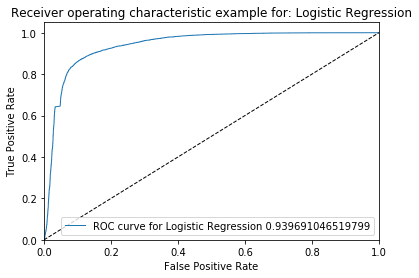

Confusion matrix is :  [[7598 1889]
 [ 716 8788]]

Classificatin report is :               precision    recall  f1-score   support

          0       0.91      0.80      0.85      9487
          1       0.82      0.92      0.87      9504

avg / total       0.87      0.86      0.86     18991


Accuracy Score is  : 0.8628297614659576


In [218]:
LogisticRegression = linear_model.LogisticRegression()

LogisticRegression.fit (x_train,y_train)
joblib.dump(LogisticRegression,'LogisticRegression.pkl')

fpr = dict()
tpr = dict()
roc_auc = dict()
prob_y = LogisticRegression.predict_proba(x_test)
predictions = LogisticRegression.predict(x_test)
fpr, tpr,thresholds = roc_curve(y_test, prob_y[:,1]) #the first column has the scores for target 1
roc_auc = auc(fpr, tpr)

# call on plotRocCurve to get the ROC curve 
plotRocCurve(fpr, tpr,roc_auc,'Logistic Regression')

# call on evaluation for metrics
evaluation(y_test,predictions)

# Analysis


# The ROC curve :
The curve shows how good a predictor is the model . With an accuracy score of 86.28% it is a good model, Since the data is balanced. 


# Confusion Matrix
the left to right diagnol gives the correct classification (True Positive and True Negative)
This is a good metric . When compared with the False Positve and False Negative.

Our model was able to pic out 7598 correct classification with  1889 it got wrong. 

But even better it was able to predict 8788 correct classification where no connection was present with the user with 716 it got wrong. 

# Classification Report
The precision , recall and F1-score are healthy.